# 1 - Sequence to Sequence Learning with Neural Networks for Household Load Data

## Imports

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import sys
import os
import random
from sklearn.preprocessing import MinMaxScaler
import time
import math
import pandas as pd
import string
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
from scipy.stats import norm
import string
from datetime import datetime
import datetime
from sklearn.metrics import mean_squared_error


import torch.nn.functional as F

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class SAXObject:
    def __init__(self, alphabet_size):
        self.df = None
        self.df_pivot = None
        self.alphabet_size = alphabet_size
        self.df_sax_numbers = None
        self.df_sax_numbers_diff = None
        self.wakeup = None
        self.days_not_at_home = None

    def timeseries_dataframe_pivot(self, df):
        """
        Takes in a dataframe of a timeseries with index of type pd.DatetimeIndex and transforms it so that 
        the index is the day and the columns are the timesteps within that day.
        """

        df["date"] = df.index.date
        df["time"] = df.index.time

        df_pivot = df.pivot(index="date", columns="time")

        n_day, n_timesteps = df_pivot.shape

        df_pivot.dropna(
            thresh=int(n_timesteps / 5), inplace=True
        )  # if more than half of the values are nan, remove that day

        df_pivot = df_pivot.fillna(
            method="ffill", axis=0
        )  # the remaining nans are copied from the previous day

        df_pivot = df_pivot.droplevel(0, axis=1)

        df_pivot.columns.name = ""

        self.df_pivot = df_pivot
        self.df = df.iloc[:, [0]]

        return df_pivot

    def unpivot_timeseries_dataframe(self, df: pd.DataFrame, column_name: str = "Q"):

        df_unstack = df.T.unstack().to_frame().reset_index()
        df_unstack.columns = ["date", "time", "{}".format(column_name)]
        df_unstack["date_str"] = df_unstack["date"].apply(
            lambda t: datetime.datetime.strftime(t, format="%Y-%m-%d")
        )
        df_unstack["time_str"] = df_unstack["time"].apply(
            lambda t: " {}:{}:{}".format(t.hour, t.minute, t.second)
        )
        df_unstack["datetime_str"] = df_unstack["date_str"] + df_unstack["time_str"]
        df_unstack = df_unstack.set_index(
            pd.to_datetime(df_unstack["datetime_str"], format="%Y-%m-%d %H:%M:%S")
        )[[column_name]]
        df_unstack.index.name = "datetime"

        return df_unstack

In [ ]:
class LoadDataset(torch.utils.data.Dataset):
    def __init__(self, X_input, X_target):
        super(LoadDataset, self).__init__()  
        self.X_input = X_input
        self.X_target = X_target

    def __len__(self):
        return (self.X_input).shape[0]

    def __getitem__(self, idx):
        return (self.X_input[idx,:,np.newaxis], self.X_target[idx,:,np.newaxis])

## Data Preparation

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/household_load_forecasting/data/load_data_15min_watts.csv", parse_dates=True, index_col=0)[["SFH42"]]


scaler = MinMaxScaler()

df[df.columns] = scaler.fit_transform(df[df.columns])

sax_obj = SAXObject(8)

In [ ]:
df_pivot = sax_obj.timeseries_dataframe_pivot(df)

In [ ]:

train_end = pd.to_datetime("2019-09-01")
target_split = int(df_pivot.shape[1] * 0.5)

train = df_pivot.loc[:train_end].to_numpy(dtype="float32")
test = df_pivot.loc[train_end:].to_numpy(dtype="float32")


/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py:3361: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return self._engine.get_loc(casted_key)
/usr/local/lib/python3.7/dist-packages/pandas/core/algorithms.py:1601: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return arr.searchsorted(value, side=side, sorter=sorter)


In [ ]:
trainset = LoadDataset(train[:,:target_split], train[:,target_split:])
testset = LoadDataset(test[:,:target_split], test[:,target_split:])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

batch_size = 8



trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size = batch_size, shuffle=False, num_workers=1)

In [ ]:
# Some helper functions

def train(model, loader, optmizer, criterion, clip):
  
  model.train()

  epoch_loss = 0
  
  for batch_idx, batch in enumerate(trainloader):
    src, trg = batch
    src = torch.tensor(src, dtype=torch.float32).to(device)
    trg = torch.tensor(trg, dtype=torch.float32).to(device)

    output = model(src, trg)
    output_ = torch.einsum("ijk->ji", output)[:,1:]
    trg_ = trg.squeeze(-1)[:,1:]
    optimizer.zero_grad()
    loss = criterion(output_,trg_)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
    optimizer.step()

    epoch_loss += loss.item()

  return epoch_loss / len(loader)


def evaluate(model, loader, criterion):

  model.eval()

  epoch_loss = 0

  with torch.no_grad():

    for batch_idx, batch in enumerate(loader):
      src, trg = batch
      src = torch.tensor(src, dtype=torch.float32).to(device)
      trg = torch.tensor(trg, dtype=torch.float32).to(device)

      output = model(src, trg, 0)
      output_ = torch.einsum("ijk->ji", output)[:,1:]
      trg_ = trg.squeeze(-1)[:,1:]
      val_loss = criterion(output_,trg_)

      epoch_loss += val_loss.item()

  return epoch_loss / len(loader)

def train_model(model, trainloader, testloader, optimizer, criterion, clip, learning_rate, epochs=1000,
                eval_every=10, verbose=1, model_name:str = "model", lr_schedule = None):
    
    best_val_loss = float('inf')

    for epoch in range(epochs):

      start_time = time.time()

      train_loss = train(model, trainloader, optimizer, criterion, clip)   
      
      end_time = time.time()
      epoch_mins, epoch_secs = epoch_time(start_time, end_time)

      if(verbose):
        if (epoch % eval_every == 0):
          val_loss = evaluate(model,testloader, criterion)

          if lr_schedule is not None:
            lr_schedule.step()
            
          print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s', ' train_loss ', train_loss, ' val_loss ', val_loss)
          
          if val_loss < best_val_loss:
            best_valid_loss = val_loss
            torch.save(model.state_dict(), '/content/drive/MyDrive/household_load_forecasting/Seq2Seq_experiments/models/{}.pt'.format(model_name))


def test_models(nets, testloader, num_batches):
  # Visualize results
  gen_test = iter(testloader)
  
  rmse_overall = {}
  
  for batch in range(len(gen_test)):
    test_inputs, test_targets = next(gen_test)

    test_inputs  = torch.tensor(test_inputs, dtype=torch.float32).to(device)
    test_targets = torch.tensor(test_targets, dtype=torch.float32).to(device) 
    
    for ind in range(1,num_batches):
        plt.figure()
        plt.rcParams['figure.figsize'] = (17.0,5.0)  
        k = 1
        for net in nets:
            pred = net.predict(test_inputs[ind,:,:].unsqueeze(0), n_ahead = 48).to(device)

            input = test_inputs.detach().cpu().numpy()[ind,:,:].flatten()
            target = test_targets.detach().cpu().numpy()[ind,:,:].flatten()
            
            preds = pred.detach().cpu().numpy().flatten()

            ground_truth = np.concatenate([input, target])

            preds_flat = np.concatenate([np.zeros((ground_truth.shape[0] - preds.shape[0])), preds])

            print(preds_flat.shape)
            print(ground_truth.shape)

            df_compare = pd.DataFrame({"ground_truth": ground_truth, "predictions": preds_flat}, index = range(ground_truth.shape[0])).replace(0, np.nan)

            df_compare_no_nans = df_compare.dropna()


            rmse = mean_squared_error(df_compare_no_nans["ground_truth"], df_compare_no_nans["predictions"], squared=False)

            plt.subplot(1,len(nets),k)
            plt.plot(df_compare["ground_truth"], label = "ground_truth")
            plt.plot(df_compare["predictions"], label = "predictions")
            plt.xticks(range(0,df_compare.shape[0],8))
            plt.legend()
            plt.title("RMSE={}".format(rmse))
            k = k+1
            plt.show()



def init_weights(model):
  for name, param in model.named_parameters():
    if "weight" in name:
      nn.init.normal_(param.data, mean = 0, std = 0.01) 
    else:
      nn.init.constant_(param.data, 0)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


# Classic Encoder-Decoder: 2014_Sutskever

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self,input_size, hidden_size, n_layers, p):
        super(Encoder, self).__init__()  
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers, batch_first = True)
        self.dropout = nn.Dropout(p)


    def forward(self, input): # input_dim [batch_size, length T, dimensionality d]      
        output, hidden = self.gru(input)      
        return hidden


class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, output_size, p):
        super(Decoder, self).__init__()   
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=n_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p)
        
    def forward(self, input, hidden):
        output, hidden = self.gru(input, hidden) 
        prediction = self.fc(output)
        return prediction, hidden



class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_force_ratio = 0.5):
        batch_size = src.shape[0]
        target_len = trg.shape[1]

        outputs = torch.zeros(target_len, batch_size, 1).to(self.device)
        
        hidden = self.encoder(src)

        x = src[:,-1:,:] #this is the first input to the decoder (the most previous known lag)

        for t in range(1, target_len):
            
            output, hidden = self.decoder(x, hidden)

            best_guess = output

            ground_truth = trg[:,t,:].unsqueeze(-1)
            x = ground_truth if random.random() < teacher_force_ratio else best_guess #sometimes we take the real value, sometimes we take the predicted value

            output_reshaped = torch.einsum('ijk->ij', output)

            outputs[t] = output_reshaped

        return outputs


    def predict(self, src, n_ahead):

        batch_size = src.shape[0]
        outputs = torch.zeros(n_ahead, batch_size, 1).to(self.device)
        
        hidden = self.encoder(src)

        x = src[:,-1:,:] #this is the first input to the decoder (the most previous known lag)

        for t in range(1, n_ahead):
            
            output, hidden = self.decoder(x, hidden)

            output_reshaped = torch.einsum('ijk->ij', output)

            outputs[t] = output_reshaped

        return outputs[1:]





In [ ]:
input_size = 1
output_size = 1
hidden_size = 512
n_layers = 1
p = 0.5

lr = 1e-3
criterion = nn.L1Loss()

enc = Encoder(input_size, hidden_size, n_layers, p)
dec = Decoder(input_size, hidden_size, n_layers, output_size, p)

model = Seq2Seq(enc, dec, device).to(device)

model.apply(init_weights)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = torch.optim.Adam(model.parameters(), lr)

The model has 1,582,593 trainable parameters


In [ ]:
train_model(model, trainloader, testloader, optimizer, criterion, clip = 1, learning_rate = lr, epochs = 150 )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


KeyboardInterrupt: ignored

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/household_load_forecasting/Seq2Seq_experiments/models/model.pt"))
model.to(device)

Seq2Seq(
  (encoder): Encoder(
    (gru): GRU(1, 512, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (gru): GRU(1, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


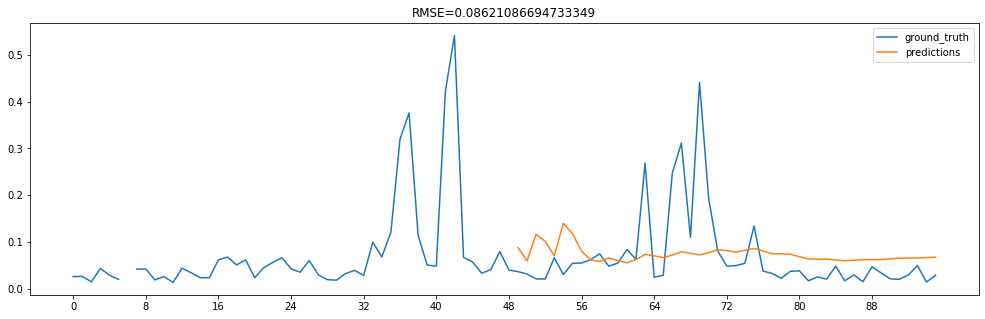

(96,)
(96,)


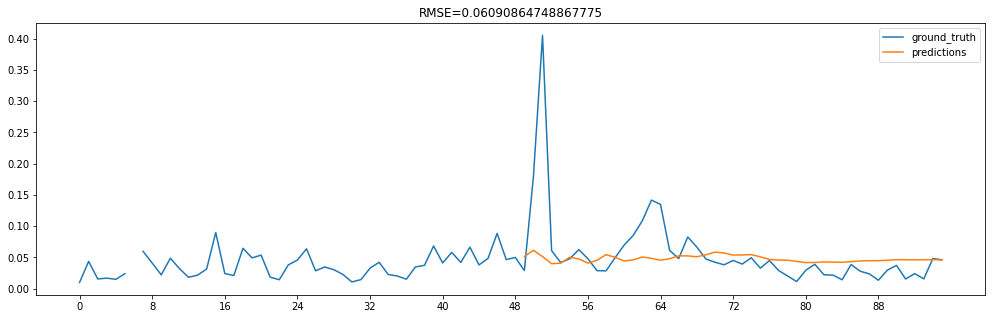

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


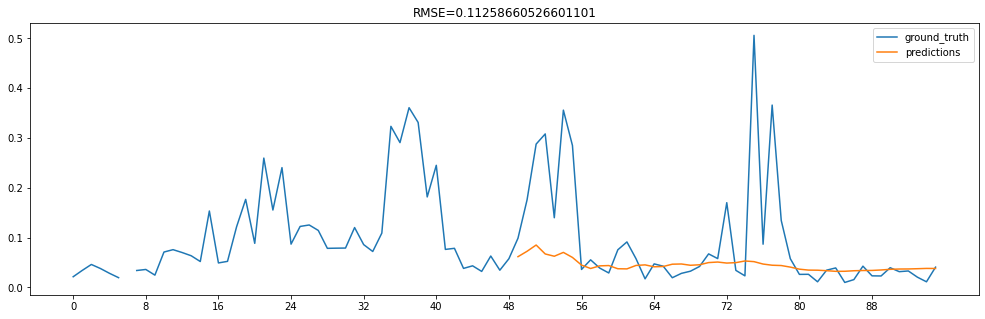

(96,)
(96,)


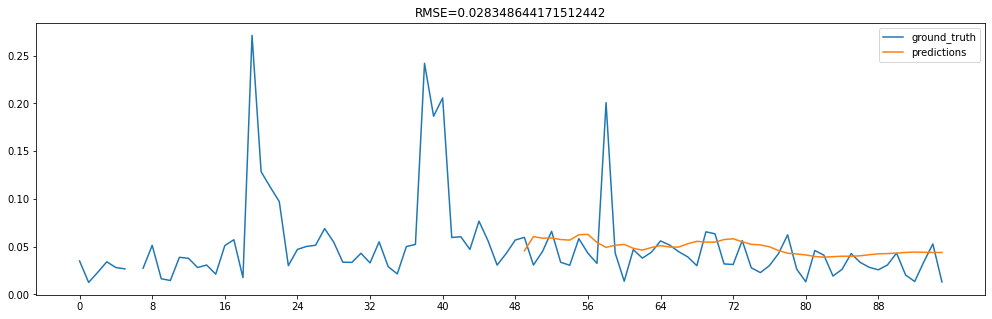

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


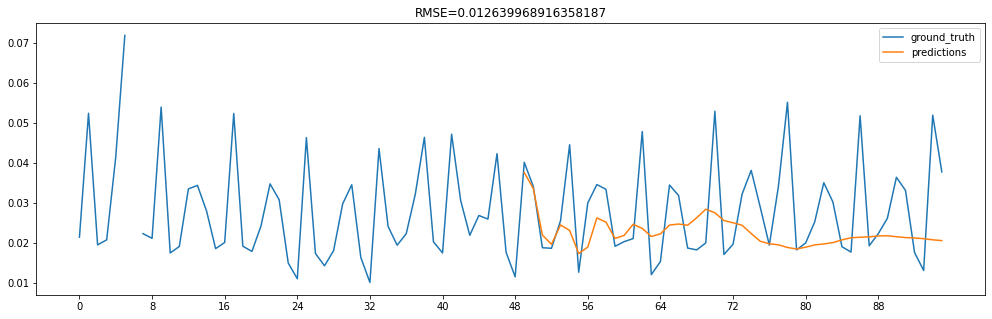

(96,)
(96,)


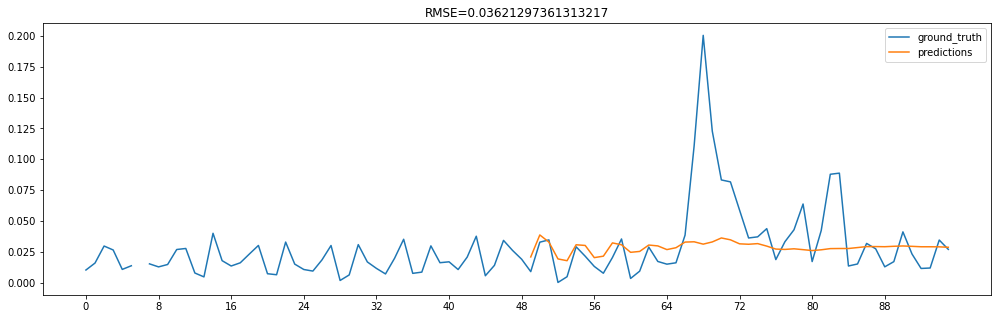

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


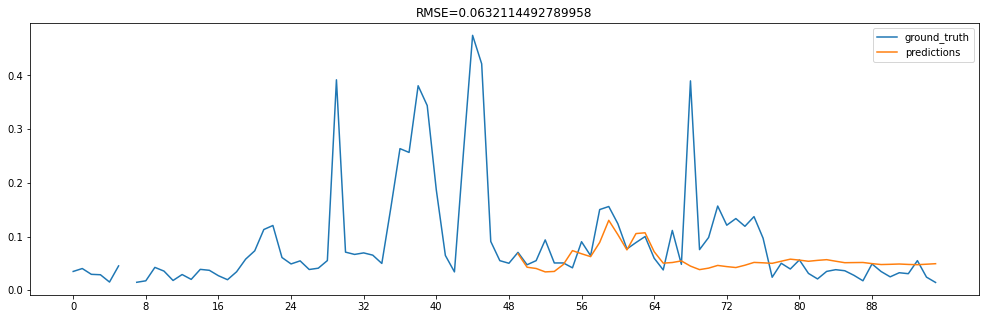

(96,)
(96,)


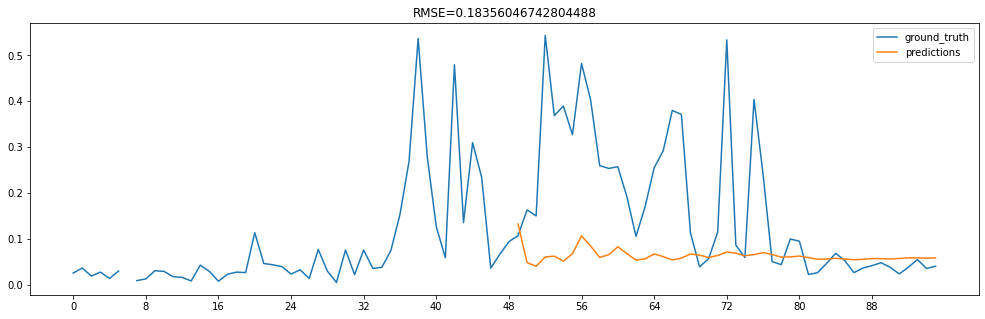

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


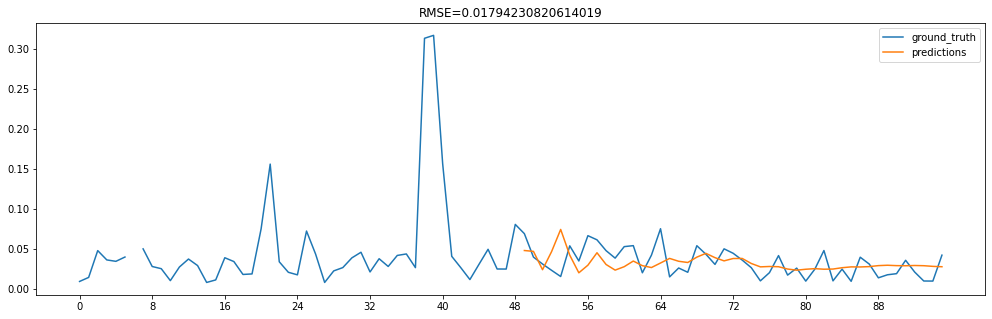

(96,)
(96,)


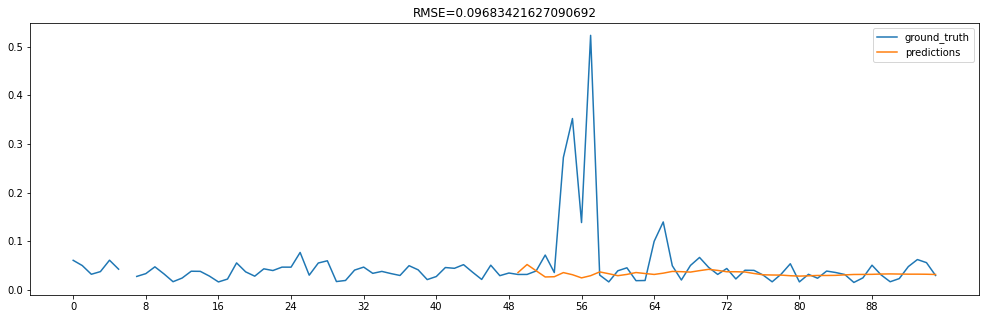

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


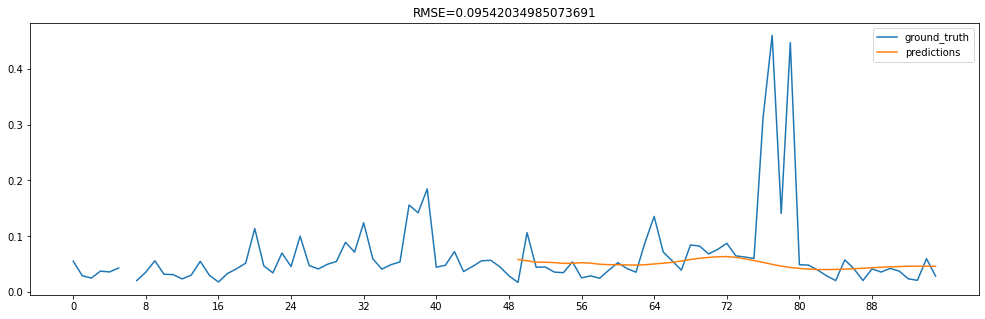

(96,)
(96,)


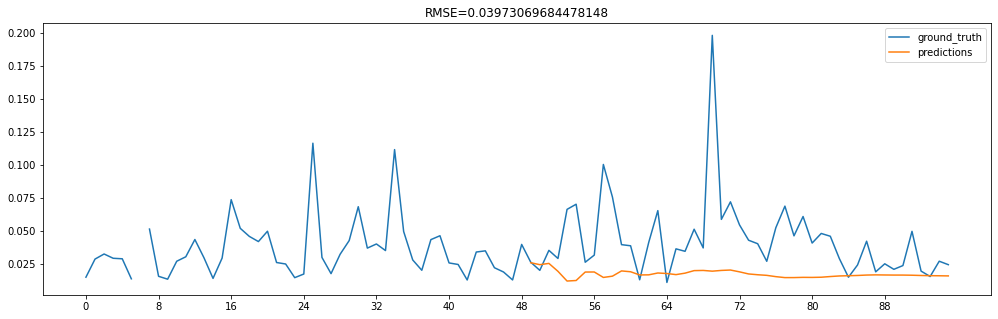

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


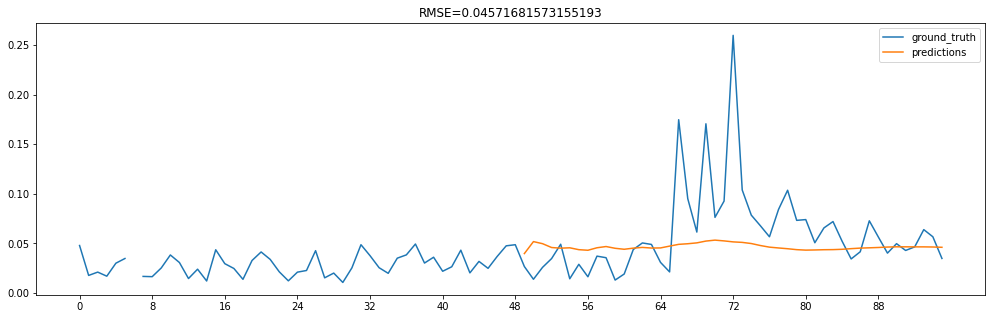

(96,)
(96,)


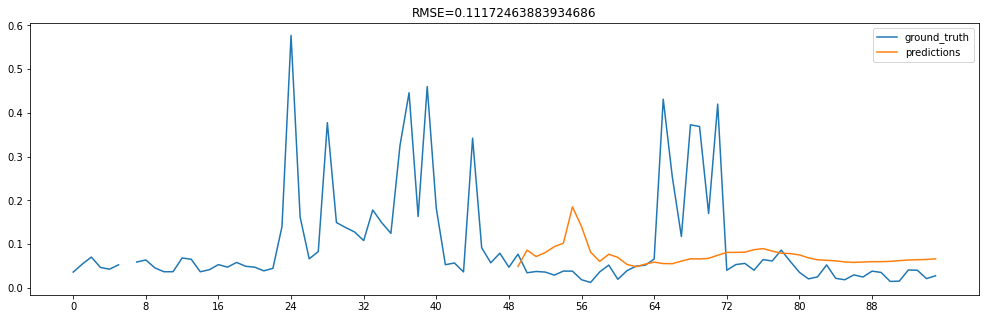

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


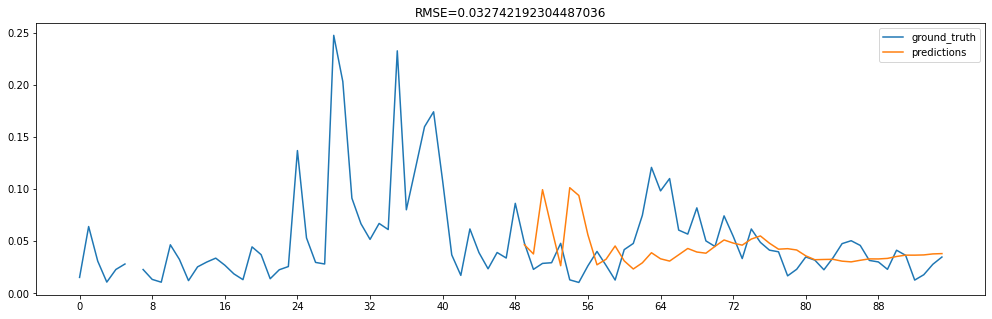

(96,)
(96,)


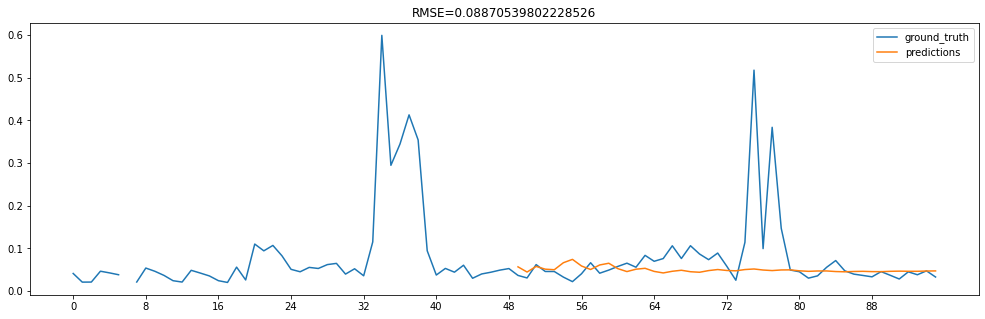

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


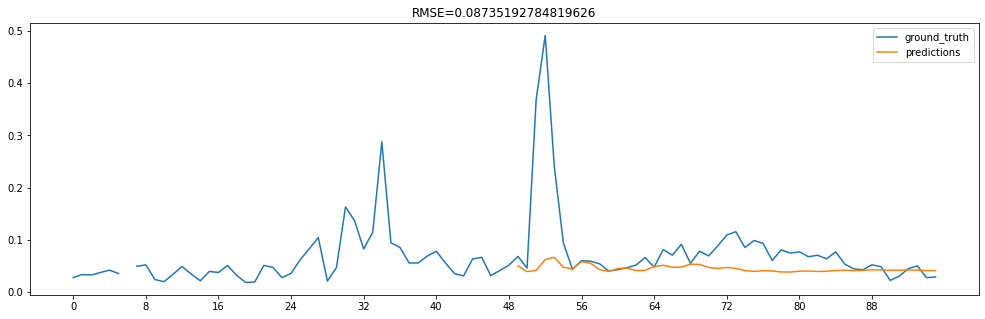

(96,)
(96,)


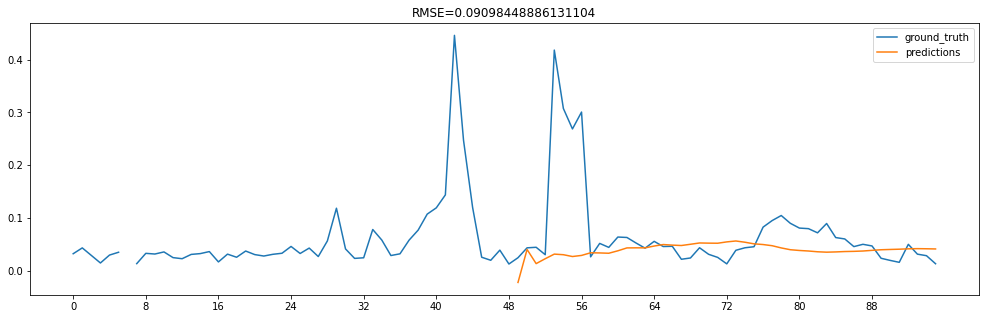

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


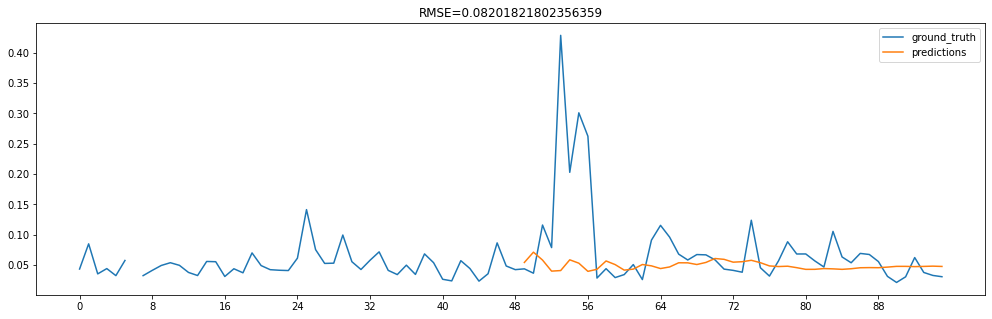

IndexError: ignored

<Figure size 1224x360 with 0 Axes>

In [ ]:
test_models([model], testloader, 3)

# Encoder-Decoder with Attention: 2016 Bahdanau/Bengio Align and Translate

https://arxiv.org/abs/1409.0473

In [ ]:
class EncoderBad(nn.Module):

    def __init__(self,input_size, hidden_size):
        super(EncoderBad, self).__init__()  
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first = True, bidirectional = True)
        self.fc = nn.Linear(hidden_size * 2, hidden_size)

    def forward(self, input):    
        outputs, hidden = self.gru(input)  


        print(outputs.shape, hidden.shape)

        hidden_con = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        hidden = torch.tanh(self.fc(hidden_con))

        print(hidden.shape)
        return outputs, hidden

class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()

    self.attn = nn.Linear(hidden_size * 3, hidden_size)
    self.v = nn.Linear(hidden_size, 1, bias = False)

  def forward(self, hidden, encoder_outputs):


    batch_size = encoder_outputs.shape[0]
    src_len = encoder_outputs.shape[1]

    hidden = hidden.unsqueeze(1).repeat(1, src_len, 1) #we open up the hidden tensor at index 1, and repeat it src length time at this index

    energy_input = torch.cat((hidden, encoder_outputs), dim = 2)

    energy = torch.tanh(self.attn(energy_input))
    attention = self.v(energy)

    return F.softmax(attention, dim = 1).squeeze(-1)



In [ ]:
src, trg = iter(trainloader).next()

src = torch.tensor(src, dtype=torch.float32).to(device)
trg = torch.tensor(trg, dtype=torch.float32).to(device)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
src.shape

torch.Size([8, 48, 1])

In [ ]:
encoder = EncoderBad(1,3)

outputs, hidden = encoder(src)


torch.Size([8, 48, 6]) torch.Size([2, 8, 3])
torch.Size([8, 3])


In [ ]:
print(hidden.shape, outputs.shape)

torch.Size([8, 3]) torch.Size([8, 48, 6])


In [ ]:
attn = Attention(3)

In [ ]:
class DecoderBad(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, attention):
      super(DecoderBad, self).__init__()   
      
      self.output_size = output_size
      self.attention = attention
      
      self.hidden_size = hidden_size
      self.gru = nn.GRU(input_size=hidden_size * 2 + input_size,  hidden_size=hidden_size, batch_first = True)
      self.fc_out = nn.Linear(hidden_size*3 + input_size, output_size)
  
    def forward(self, input, hidden, encoder_outputs):


      # encoder_outputs = [batch_size, src_len, hidden_size * 2]
      # hidden = [batch_size, hidden_size]
      # input = [batch_size] only one word / number per timestep

      input = input.unsqueeze(-1)
      
      # input = [batch_size, 1]

      # a = [batch_size, src_len]
      a = self.attention(hidden, encoder_outputs)
      a = a.unsqueeze(1) 
      # a = [batch_size,1, src_len]

      weighted = torch.einsum('bki, bjh-> bkh',[a,encoder_outputs])
      #weighted = [batch_size, 1, 2*hidden_size]

      rnn_input = torch.cat((input, weighted), dim = 2)


      #rnn_input = [batch_size, 1, hidden_size * 2 + input_size]

      output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))


      prediction = self.fc_out(torch.cat((output, weighted, input), dim = 2)).squeeze(-1)


      return prediction, hidden.squeeze(0)
      

class Seq2Seq_Bad(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq_Bad, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_force_ratio = 0.5):
        batch_size = src.shape[0]
        target_len = trg.shape[1]

        outputs = torch.zeros(target_len, batch_size, self.decoder.output_size).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src)

        x = src[:,-1,:] #this is the first input to the decoder (the most previous known lag)

        for t in range(1, target_len):
                
            output, hidden = self.decoder(x, hidden, encoder_outputs)

            best_guess = output

            ground_truth = trg[:,t,:]
            
            x = ground_truth if random.random() < teacher_force_ratio else best_guess #sometimes we take the real value, sometimes we take the predicted value

            outputs[t] = torch.einsum('ij-> ji', output).unsqueeze(-1)

        return outputs


    def predict(self, src, n_ahead):

        batch_size = src.shape[0]
        outputs = torch.zeros(n_ahead, batch_size, 1).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src)

        x = src[:,-1,:] #this is the first input to the decoder (the most previous known lag)

        for t in range(1, n_ahead):
            
            output, hidden = self.decoder(x, hidden, encoder_outputs)

            outputs[t] = torch.einsum('ij-> ji', output).unsqueeze(-1)

        return outputs[1:]


In [ ]:
input_size = 1
output_size = 1
hidden_size = 256

lr = 1e-4
criterion = nn.L1Loss()

attention = Attention(hidden_size)
enc = EncoderBad(input_size, hidden_size)
dec = DecoderBad(input_size, hidden_size, output_size, attention)

model_bad = Seq2Seq_Bad(enc, dec, device).to(device)

model_bad.apply(init_weights)

print(f'The model has {count_parameters(model_bad):,} trainable parameters')

optimizer = torch.optim.Adam(model_bad.parameters(), lr)

scheduler = ReduceLROnPlateau(optimizer, 'min')


The model has 1,319,170 trainable parameters


In [ ]:
train_model(model_bad, trainloader, testloader, optimizer, criterion, clip = 1, learning_rate = lr, epochs = 300, model_name = "model_bad", lr_schedule = scheduler)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(96,)
(96,)


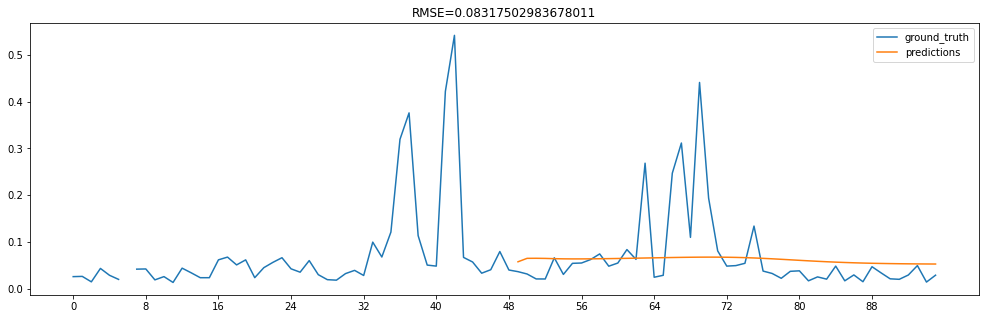

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(96,)
(96,)


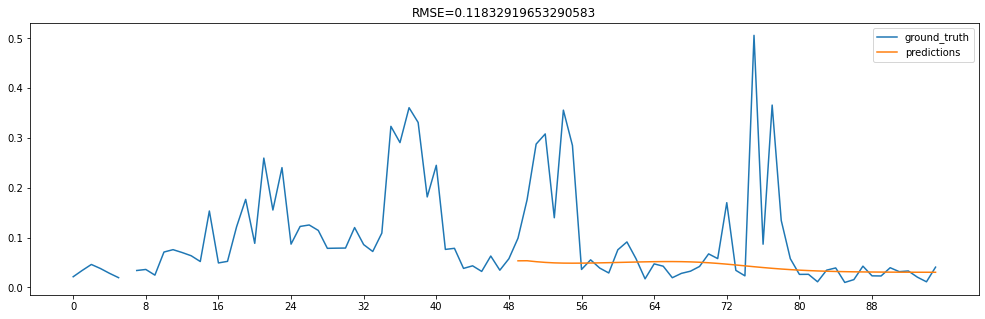

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


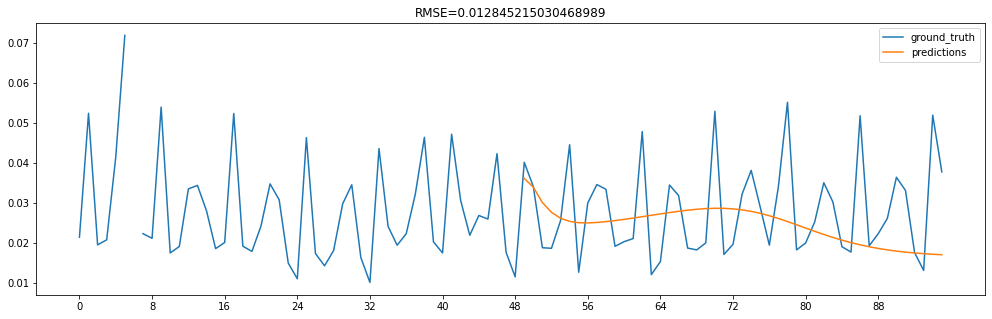

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


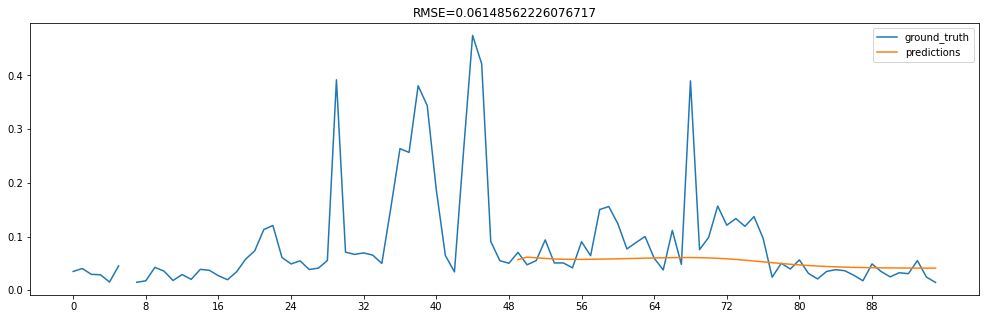

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


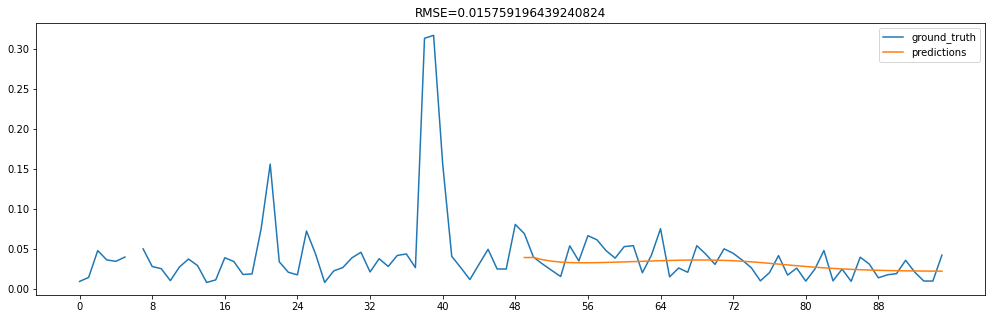

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(96,)
(96,)


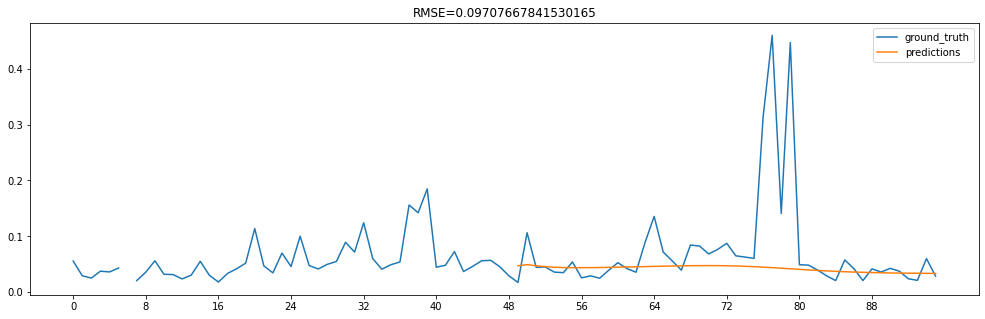

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


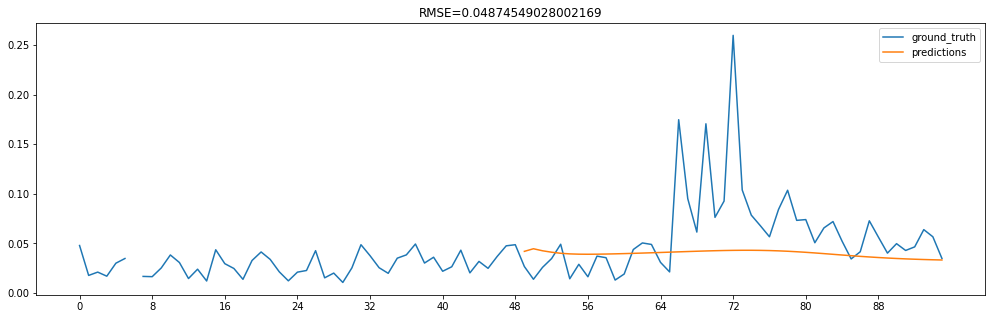

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


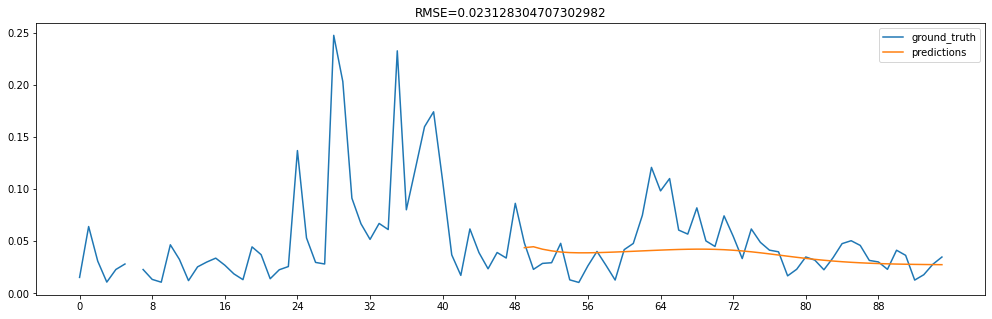

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


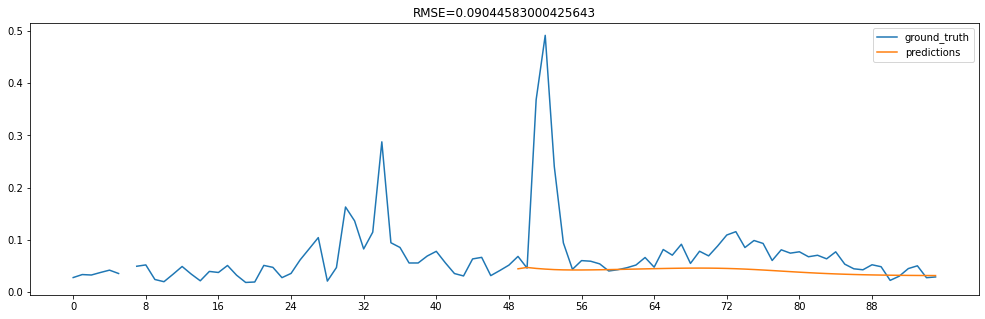

(96,)
(96,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


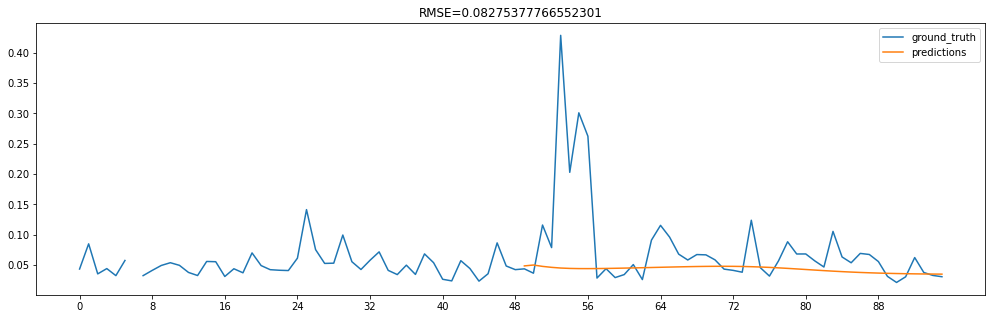

In [ ]:

model_bad.load_state_dict(torch.load("/content/drive/MyDrive/household_load_forecasting/Seq2Seq_experiments/models/model_bad.pt"))
model_bad.to(device)

test_models([model_bad], testloader, 2)

# Convolutional Seq2Seq

https://arxiv.org/abs/1705.03122

### Encoder

In [ ]:
class EncoderConv(nn.Module):
  def __init__(self, input_size, emb_size, hid_size, n_layers, kernel_size, dropout, device, max_length= 100):
    super(EncoderConv, self).__init__()

    assert kernel_size % 2 == 1, "Kernel size must be odd!"

    self.device = device
    # The scale variable is used by the authors to "ensure that the variance
    # throughout the network does not change dramatically".
    # The performance of the model seems to vary wildly
    # using different seeds if this is not used.
    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device) # ~ 0.7
    self.tok_emb = nn.Linear(input_size,emb_size)
    self.pos_emb = nn.Embedding(max_length, emb_size)
    self.emb2hid = nn.Linear(emb_size, hid_size)
    self.hid2emb = nn.Linear(hid_size, emb_size)
    self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_size,
                                          out_channels = 2*hid_size,
                                          kernel_size = kernel_size,
                                          padding = (kernel_size -1) // 2
                                          )
                                for _ in range(n_layers)])
    self.dropout = nn.Dropout(dropout)


  def forward(self, src):
    batch_size = src.shape[0]
    src_len = src.shape[1]

    #pos = [batch_size, src_len] (of the longest seq in the batch)
    pos = torch.arange(0,src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    tok_embedded = self.tok_emb(src)
    pos_embedded = self.pos_emb(pos)

    #element-wise summing of embeddings
    #embedded = [batch_size, src_len, emb_size]
    embedded = self.dropout(tok_embedded + pos_embedded)

    #conv_input = [batch_size, src_len, hidden_size]
    conv_input = self.emb2hid(embedded)

    conv_input = torch.einsum('ijk->ikj', conv_input)

    # conv likes dims = [batch_size, hidden_size, src_len]; n = batches, C_in = channels / hidden, L = length
    # https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
    for i, conv in enumerate(self.convs):

      conved = conv(self.dropout(conv_input))

      conved = F.glu(conved, dim = 1) # 1 (k) dim is now [hidden_size * 2]

      #residual

      #print(self.scale)
      conved = (conved + conv_input) * self.scale # 

      conv_input = conved


    conved = torch.einsum('ikj->ijk', conved)
    conved = self.hid2emb(conved)

    combined = (conved + embedded) * self.scale

    return conved, combined




                                                    



In [ ]:
enc_conv = EncoderConv(input_size=1, emb_size=1, hid_size=3, n_layers=2, kernel_size= 3, dropout = 0.5, device = device)

In [ ]:
conved, combined = enc_conv(src)


torch.Size([8, 48, 1])

### Decoder

In [ ]:
class DecoderConv(nn.Module):

  def __init__(self,
               input_size,
               emb_size,
               hid_size,
               output_size,
               n_layers,
               kernel_size,
               dropout,
               trg_pad_idx,
               device, 
               max_length=100):
    
    super(DecoderConv, self).__init__()
    
    self.device = device
    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device) # ~ 0.7
    self.input_size = input_size
    self.hid_size = hid_size
    self.kernel_size = kernel_size
    self.trg_pad_idx = trg_pad_idx

    self.dropout = nn.Dropout(dropout)
    self.tok_emb = nn.Linear(input_size, emb_size)
    self.pos_emb = nn.Embedding(max_length, emb_size)
    self.emb2hid = nn.Linear(emb_size, hid_size)
    self.hid2emb = nn.Linear(hid_size, emb_size)
    self.att_hid2emb = nn.Linear(hid_size, emb_size)
    self.att_emb2hid = nn.Linear(emb_size, hid_size)
    self.fc_out = nn.Linear(emb_size, output_size)


    self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_size,
                                          out_channels = 2*hid_size,
                                          kernel_size = kernel_size
                                          )
                                for _ in range(n_layers)])



  def calc_att(self, embedded, conved, encoder_conved, encoder_combined):

    
    #encoder_conved = [N, src, emb]
    #encoder_combined = [N, src, emb]

    #conved; it comes out [N, hid_size, trg] from the conv1d layer 
    conved_permuted = torch.einsum('nht->nth', conved)
    # -> [N, trg, hid]


    conved_emb = self.att_hid2emb(conved_permuted)
    # [N, trg, emb]

    combined = (conved_emb + embedded) * self.scale

    encoder_conved_perm = torch.einsum('nse->nes', encoder_conved)

    energy = torch.einsum('nte,nes->nts', [combined, encoder_conved_perm])

    attention = F.softmax(energy, dim = 2) #over the source dimension, because later the encoders are weighted

    attended_encoding = torch.einsum('nts, nse->nte', attention, encoder_combined)

    attended_encoding = self.att_emb2hid(attended_encoding)
    #[N, trg, hid]

    attended_combined = (attended_encoding.permute(0,2,1) + conved) * self.scale


    return attention, attended_combined



  def forward(self, trg, encoder_conved, encoder_combined):

    batch_size = trg.shape[0]
    trg_len = trg.shape[1]

    pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

    tok_embedded = self.tok_emb(trg)
    pos_embedded = self.pos_emb(pos)

    embedded = self.dropout(tok_embedded + pos_embedded)

    conv_input = self.emb2hid(embedded)

    conv_input = torch.einsum('nth->nht', conv_input)

    for i, conv in enumerate(self.convs):

      conv_input = self.dropout(conv_input)

      # padding
      padding = torch.zeros(batch_size, self.hid_size, self.kernel_size -1).fill_(self.trg_pad_idx).to(self.device)

      padded_conv_input = torch.cat((padding, conv_input), dim = 2)
      # [N, h, t+k-1]

      conved = conv(padded_conv_input)
      # [N, 2*h, t]

      conved = F.glu(conved, dim = 1) #glu halves the dimension, this is why we setup the convs that way

      # [N, h , t]

      attention, conved = self.calc_att(embedded, conved, encoder_conved, encoder_combined)
      # att: [N, t, s]
      #conved: [N, h, t]

      conved = (conved + conv_input) * self.scale

      conv_input = conved #pass to the next layer


    conved = self.hid2emb(conved.permute(0,2,1))
    # [N, t, e]

    output = self.fc_out(self.dropout(conved))
    # [N, t, 1]

    return output, attention



In [ ]:

batch = iter(trainloader).next()
src, trg = batch
src = torch.tensor(src, dtype=torch.float32).to(device)
trg = torch.tensor(trg, dtype=torch.float32).to(device)



dec = DecoderConv(
               input_size = 1,
               emb_size = 1,
               hid_size = 3,
               output_size = 1,
               n_layers= 2,
               kernel_size=3,
               dropout=0.1,
               trg_pad_idx= 1,
               device=device, 
               max_length=100)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


In [ ]:
output, attn = dec(trg, conved, combined)

In [ ]:
class Seq2SeqConv(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
           
        #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
        #encoder_conved is output from final encoder conv. block
        #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
        #  positional embeddings 
        encoder_conved, encoder_combined = self.encoder(src)
            
        #encoder_conved = [batch size, src len, emb dim]
        #encoder_combined = [batch size, src len, emb dim]
        
        #calculate predictions of next words
        #output is a batch of predictions for each word in the trg sentence
        #attention a batch of attention scores across the src sentence for 
        #  each word in the trg sentence
        output, attention = self.decoder(trg, encoder_conved, encoder_combined)
        
        #output = [batch size, trg len - 1, output dim]
        #attention = [batch size, trg len - 1, src len]
        
        return output, attention

In [ ]:
TRG_PAD_IDX = 1e-10


enc_conv = EncoderConv(input_size=1,
                       emb_size=1,
                       hid_size=3,
                       n_layers=2, 
                       kernel_size= 3,
                       dropout = 0.5, 
                       device = device)

dec_conv = DecoderConv(
               input_size = 1,
               emb_size = 1,
               hid_size = 3,
               output_size = 1,
               n_layers= 2,
               kernel_size=3,
               dropout=0.1,
               trg_pad_idx= TRG_PAD_IDX,
               device=device, 
               max_length=100)

model_conv = Seq2SeqConv(enc_conv, dec_conv).to(device)

In [ ]:
print(f'The model has {count_parameters(model_conv):,} trainable parameters')

The model has 476 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

In [ ]:
def generate_square_subsequent_mask(dim1: int, dim2: int):
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Modified from: 
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)


In [ ]:
generate_square_subsequent_mask(3,3)

tensor([[0., -inf, -inf],
        [0., 0., -inf],
        [0., 0., 0.]])